In [110]:
# -*- coding: utf-8 -*-
# Packages ------------------------
import os
import scipy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FDEM import Initialize as FDEM
from FDEM import Properties as Prop
from FDEM import Modeling as Mod
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.spatial import cKDTree
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
from scipy import constants
from scipy.interpolate import griddata
from utils.spatial_utils import utm_to_epsg
from utils.profile_utils import smooth_profiles, clip_profiles_to_max_depth, plot_combined_profiles
from PyPDF2 import PdfMerger
from matplotlib.ticker import MultipleLocator

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [111]:
# Parameters
cl = 0.3       # 0.2, 0.3, 0.4
percent = 20   # 10, 20, 30
s_site = 'M'

In [112]:
# User input
export_results = True # if True calibrated files are exported as .csv

config = {}
datafolder = 'data' # data folder


config['instrument_code'] = 'Dualem-21HS'
config['instrument_height'] = 0.165
config['instrument_orientation'] = 'HCP'
config['raw'] = True

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if config['instrument_code'] == 'Dualem-21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'
cal_folder = os.path.join(datafolder, 'calibrated')
os.makedirs(cal_folder, exist_ok=True) 

Raw_emfile_prefix = 'Raw/'+emfile_prefix + '_raw'

if config['raw']:
    emfile_prefix = emfile_prefix + '_raw'

raw_em_data = os.path.join(datafolder, f'{Raw_emfile_prefix}.csv')
ert_file = os.path.join(datafolder, 'ERT/'+f'{profile_prefix}-inv-ERT-'+str(cl)+'_'+str(percent)+'.csv')
#samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')
###
print('ert_file', ert_file)
config['ert_file'] = ert_file
config['em_file'] = raw_em_data

config['transform'] = False
config['utmzone'] = '31N'
config['target_cs'] = 'EPSG:31370'

# Profile selection criteria
# filter out profiles that don't reach the min_depth)
config['min_depth'] = -4.0 # minimum profile depth
config['max_depth'] = -6.0
config['surf_depth'] = -0.1
# remove profiles at transect edges
prof_excl = 10  # number of profiles to exclude from the start and end (none = 0)

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# Data import and structuring into dataframe
ert_p = pd.read_csv(config['ert_file'], sep=',', header=0)
EM_data = pd.read_csv(config['em_file'], sep=',', header=0)
print('EM_data', EM_data)
save_fig = True

if config['transform']:
    # Create a new filename with the target EPSG code
    EM_data = utm_to_epsg(EM_data, config['utmzone'], target_epsg=config['target_cs'])
    transformed_path = os.path.join(datafolder, f'{emfile_prefix}_Lam72.csv')
    EM_data.to_csv(transformed_path, index=False)

ert_file data\ERT/middelkerke-inv-ERT-0.3_20.csv
EM_data                  x            y         z         t  HCP1QP  PRP1QP  HCP2QP  \
0      41563.15402  204149.1651  0.358554  45474.80   148.5    46.2   199.1   
1      41563.15309  204149.1669  0.358554  45475.00   148.5    46.2   199.1   
2      41563.15194  204149.1691  0.358554  45475.17   148.5    46.2   199.1   
3      41563.15023  204149.1724  0.358554  45475.38   148.5    46.2   199.1   
4      41563.14844  204149.1758  0.358554  45475.58   148.5    46.2   199.1   
...            ...          ...       ...       ...     ...     ...     ...   
30149  41737.92416  204225.0505  0.350000  54617.16   191.9    85.5   231.9   
30150  41737.91989  204225.0517  0.350000  54617.36   191.9    85.5   231.9   
30151  41737.91694  204225.0526  0.350000  54617.57   191.9    85.5   231.9   
30152  41737.91599  204225.0529  0.350000  54617.77   191.9    85.5   231.9   
30153  41737.91598  204225.0529  0.350000  54629.55   191.9    85.5   231.

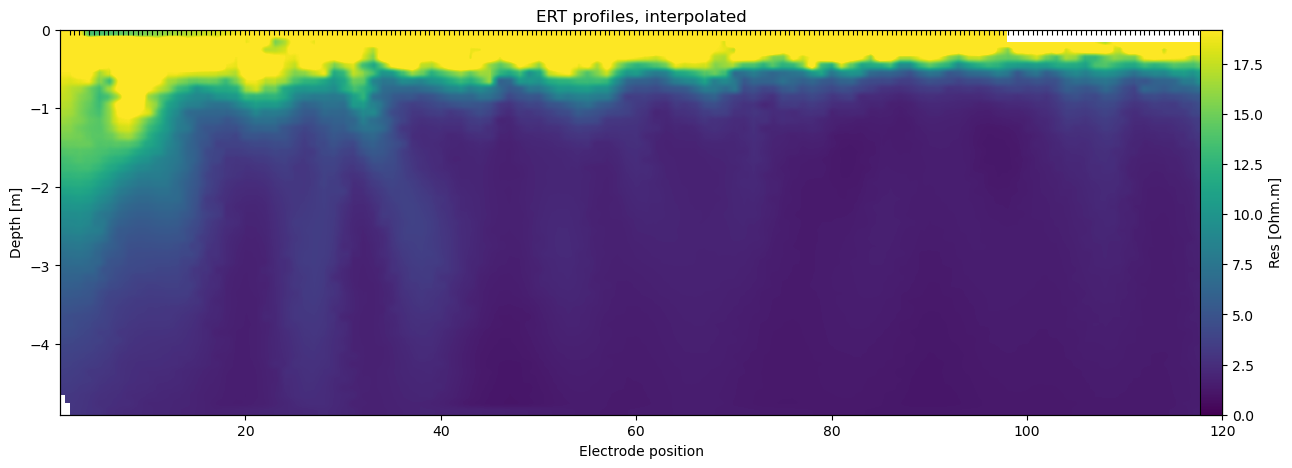

In [113]:
## Visualise ERT data

ert_p['Resistivity(ohm.m)'].describe()

points = np.column_stack((ert_p['ID'].values, ert_p['Z'].values))
min_x = ert_p['ID'].min()
max_x = ert_p['ID'].max()
min_y = ert_p['Z'].min()
max_y = ert_p['Z'].max()

num_points_x = 1000  # number of points along x-axis in the grid
num_points_y = 1000  # number of points along y-axis in the grid
desired_spacing_x = 0.1  # Desired spacing between grid points along the x-axis
desired_spacing_y = 0.1  # Desired spacing between grid points along the y-axis

num_points_x = int((max_x - min_x) / desired_spacing_x)
num_points_y = int((max_y - min_y) / desired_spacing_y)

# Calculate mean and standard deviation of the original data values
mean_values = ert_p['Resistivity(ohm.m)'].mean()
std_values = ert_p['Resistivity(ohm.m)'].std()

# Define the color scale range based on 2 standard deviations
vmin = 0 #mean_values - 2 * std_values
vmax = mean_values + 2 * std_values

# Define the grid onto which you want to interpolate
grid_x, grid_y = np.mgrid[min_x:max_x:complex(0, num_points_x), min_y:max_y:complex(0, num_points_y)]

# Interpolate the data to the grid
grid_z = griddata(points, ert_p['Resistivity(ohm.m)'], (grid_x, grid_y))

# Create the main plot
fig, ax = plt.subplots(figsize=[15, 5])
cax = ax.imshow(
    grid_z.T,
    extent=(min_x, max_x, min_y, max_y),
    origin='lower',
    vmin=vmin,
    vmax=vmax,
    cmap='viridis',
    aspect='auto'
)

# Set the plot title and labels
ax.set_title('ERT profiles, interpolated')
ax.set_xlabel('Electrode position')
ax.set_ylabel('Depth [m]')

# Create a twin axis for independent top x-axis ticks
ax2 = ax.twiny()  # This creates a new x-axis at the top
ax2.xaxis.set_ticks_position('top')  # Ensure ticks are at the top
ax2.tick_params(axis='x', which='both', direction='in')

# Set the tick locations on the top x-axis
n = 0.5  # Your desired tick spacing
tick_spacing = n
tick_locations = np.arange(min_x, max_x, tick_spacing)
ax2.set_xticks(tick_locations)

# If desired: remove or set custom tick labels for the top axis
ax2.set_xticklabels([])
# ax2.set_xticklabels(custom_labels)

# Make the new y-axis invisible (since it's not used)
ax2.yaxis.set_visible(False)

# Create an axis for the colorbar to the right of 'ax'
divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="2%", pad=0.05)

# Adjust the position of cax2 if needed
# For example, move it further to the right
pos = cax2.get_position()  # Get the original position
new_pos = [pos.x0 + 0.05, pos.y0, pos.width, pos.height]  # Increase x0 to move it right
cax2.set_position(new_pos)

cbar = fig.colorbar(cax, cax=cax2)
cbar.set_label('Res [Ohm.m]')
# Show the plot
if save_fig:
    filename = f'ERT_{profile_prefix}.pdf'
    plt.savefig(filename)
plt.show()


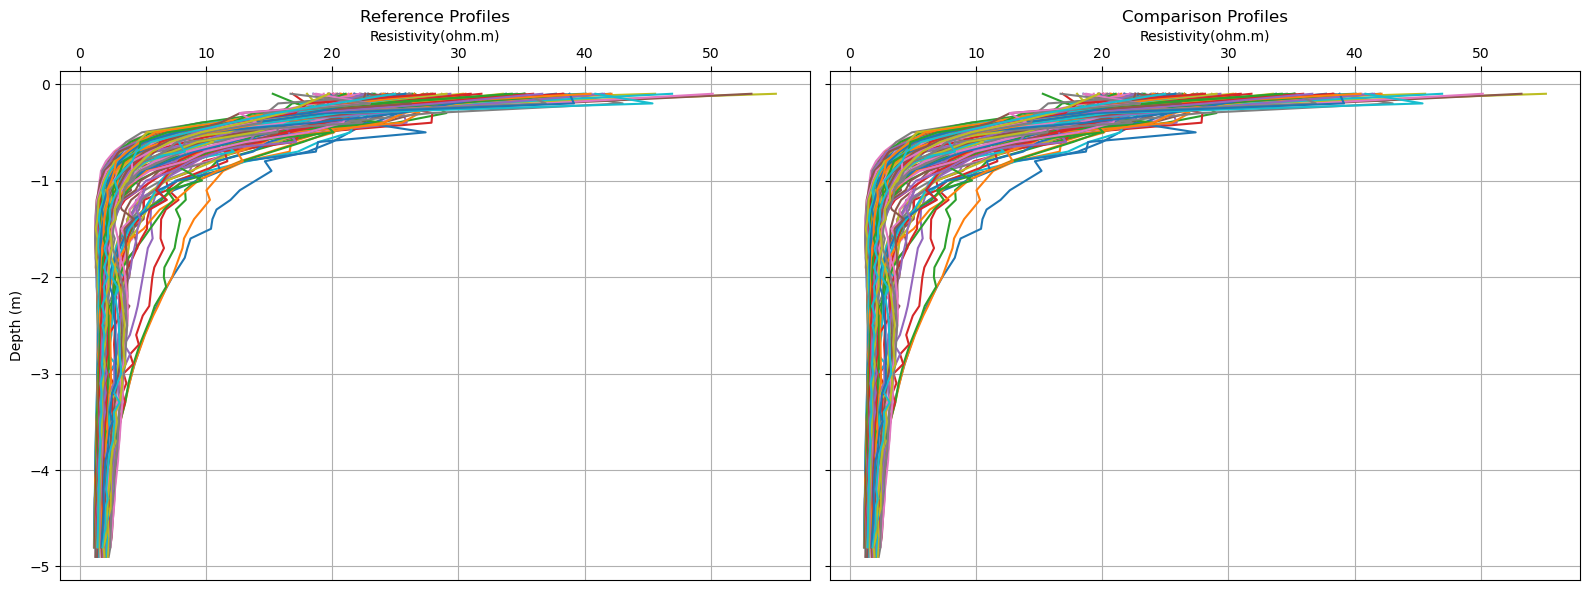

In [114]:
# Group each ERT profile per electrode location
# ---------------------------------------------#

# Group the data by profile ID for efficient access to each profile
profiles = ert_p.groupby('ID')

# 2] Filter the profile Resistivity data with a simple moving average

ert_p_smoothed = ert_p.groupby('ID').apply(lambda x: smooth_profiles(x, 'Resistivity(ohm.m)', 'Z', window_size))

# 3] Filter out profiles that don't reach min_depth
depth_filter = ert_p.groupby('ID').apply(lambda g: g['Z'].min() <= config['min_depth'])
filtered_profile_ids = depth_filter.index[depth_filter]
ert_p_depth_filtered = ert_p[ert_p['ID'].isin(filtered_profile_ids)]

# 4] Exclude the first and last n profiles
unique_ids = ert_p['ID'].unique()
# This will select profiles excluding the first and last n
selected_ids = unique_ids[prof_excl:-prof_excl]  # This is based on your earlier selection criteria
ert_p_selected = ert_p_smoothed.loc[ert_p_smoothed['ID'].isin(selected_ids)]

ert_final = clip_profiles_to_max_depth(ert_p_selected, config['max_depth'], config['surf_depth'])

dataset_name = 'Resistivity(ohm.m)'  # The variable of interest

# Reset the index without inserting it as a column
ert_final = ert_final.reset_index(drop=True)

# Now group by 'ID' and find the minimum 'Z' value for each group
min_depths_per_profile = ert_final.groupby('ID')['Z'].max()

# Convert the Series to a DataFrame for better display and manipulation
min_depths_df = min_depths_per_profile.reset_index()
min_depths_df.columns = ['Profile ID', 'Minimum Depth']
#print(min_depths_df)

# Plotting combined profiles
plot_combined_profiles(ert_final, ert_final, dataset_name)

<Figure size 1000x800 with 0 Axes>

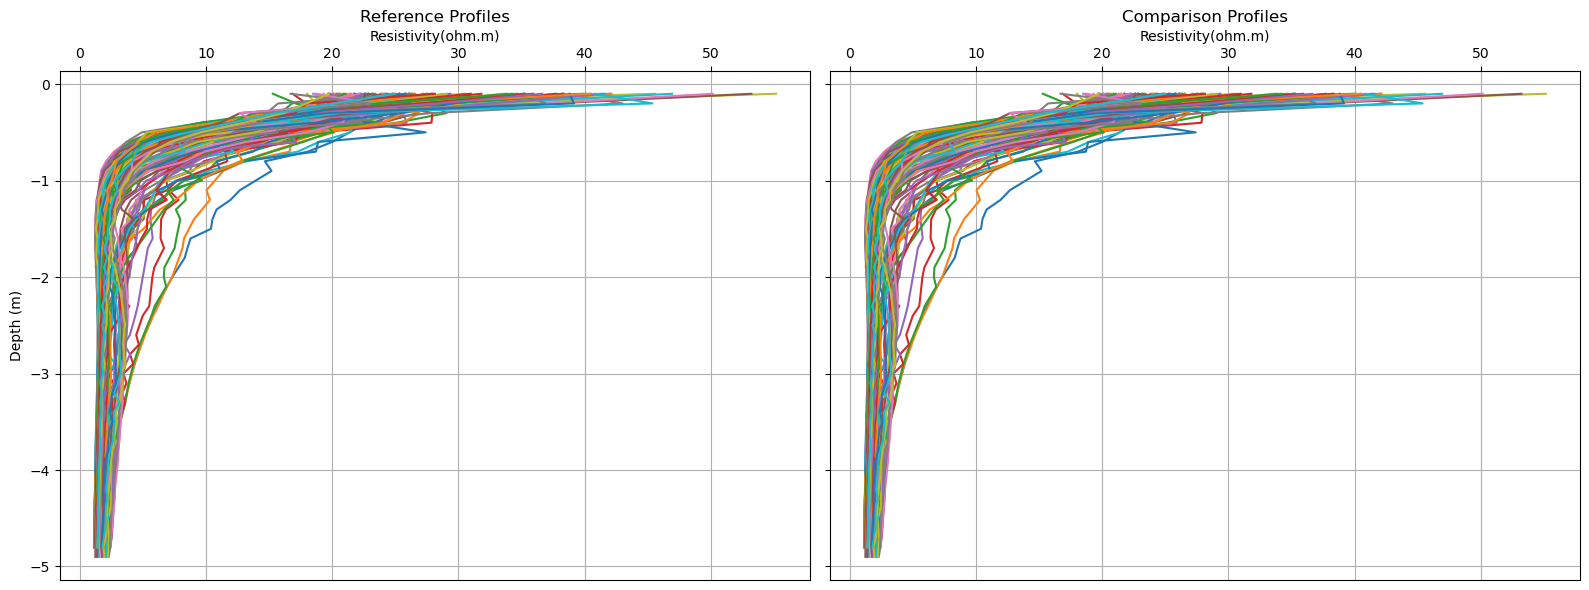

In [115]:
# Homogenise ERT profiles (assure uniform depth extent and intervals
# ----------------------------------------------------------------- #

def check_uniformity_and_interpolate(df, profile_id_col, depth_col, *data_cols):
    # Initialize a DataFrame to store both interpolated and non-interpolated profiles
    all_profiles_df = pd.DataFrame()
    uniform_intervals = {}

    # Prepare the figure for plotting non-uniform depth intervals
    plt.figure(figsize=(10, 8))
    
    # Keep track of any profiles that have been plotted (i.e., non-uniform intervals)
    plotted_profiles = []

    for profile_id, group in df.groupby(profile_id_col):
        depth_diffs = group[depth_col].diff().dropna().abs()
        
        # Find the most common interval
        common_interval = depth_diffs.mode()[0]
        
        # Check if the depth differences are uniform
        if np.isclose(depth_diffs, common_interval).all():
            # Record the uniform interval
            uniform_intervals[profile_id] = common_interval
            # Add this profile's data as is to the all_profiles_df
            all_profiles_df = pd.concat([all_profiles_df, group])
        else:
            # Add profile to the list of plotted profiles for the combined histogram
            plotted_profiles.append(profile_id)
            #plt.hist(depth_diffs, bins=30, alpha=0.5, label=f'Profile ID {profile_id}')

            # Interpolate to make uniform intervals
            interp_funcs = {col: interp1d(group[depth_col], group[col], kind='linear', bounds_error=False, fill_value='extrapolate') for col in data_cols}
            new_depths = np.arange(group[depth_col].min(), group[depth_col].max() + common_interval, common_interval)
            interpolated_values = {col: interp_funcs[col](new_depths) for col in data_cols}
            interpolated_df = pd.DataFrame(interpolated_values, index=new_depths)
            interpolated_df[profile_id_col] = profile_id  # Add the profile ID

            # Copy other non-interpolated columns
            for col in df.columns.difference([profile_id_col, depth_col] + list(data_cols)):
                interpolated_df[col] = group.iloc[0][col]
            
            interpolated_df.reset_index(inplace=True)
            interpolated_df.rename(columns={'index': depth_col}, inplace=True)
            all_profiles_df = pd.concat([all_profiles_df, interpolated_df])
    
    # # Plot the combined histogram of depth intervals for all non-uniform profiles
    # if plotted_profiles:
    #     plt.title('Depth Interval Distributions for Non-uniform Profiles')
    #     plt.xlabel('Depth Intervals')
    #     plt.ylabel('Frequency')
    #     plt.legend()
    #     plt.show()
    # else:
    #     plt.close()

    # Reset index for the concatenated DataFrame
    all_profiles_df.reset_index(drop=True, inplace=True)

    return all_profiles_df, uniform_intervals

# Columns containing the resistivity data
data_columns = ['Resistivity(ohm.m)', 'Smoothed']
# Assuming ert_final is your DataFrame with profile data
all_profiles_df, uniform_intervals = check_uniformity_and_interpolate(
    ert_final, 'ID', 'Z', *data_columns
)

dataset_name = 'Resistivity(ohm.m)'  # The variable of interest
# Plotting combined profiles
plot_combined_profiles(ert_final, all_profiles_df, dataset_name)

In [116]:
# Create forward model inputs per ERT profile (based on number of layers)
# ---------------------------------------------------------------------- #
def generate_forward_model_inputs(df, profile_id_col, depth_col, res_col):
    models = {}  # Dictionary to store models by profile ID

    for profile_id, group in df.groupby(profile_id_col):
        # Assuming uniform interval after previous interpolation
        uniform_interval = group[depth_col].diff().iloc[1]
        num_layers = len(group[res_col])

        # Thicknesses are the intervals between depths, except for the last value which does not define a new layer
        thick = np.full(num_layers - 1, uniform_interval)
        thick[0] = 2 * thick[0]
        # Conductivity is the inverse of resistivity
        con = 1 / group[res_col].values
        # Permittivity is the epsilon_0 for all layers
        perm = np.full(num_layers, constants.epsilon_0)

        # Susceptibility is 0.0 for all layers
        sus = np.zeros(num_layers)

        # Create model instance
        M = FDEM.Model(thick, sus[::-1], con[::-1], perm[::-1])
        
        # Store the model instance in the dictionary with the profile ID as the key
        models[profile_id] = M
    return models

# Use the function with your DataFrame
models = generate_forward_model_inputs(all_profiles_df, 'ID', 'Z', 'Smoothed')

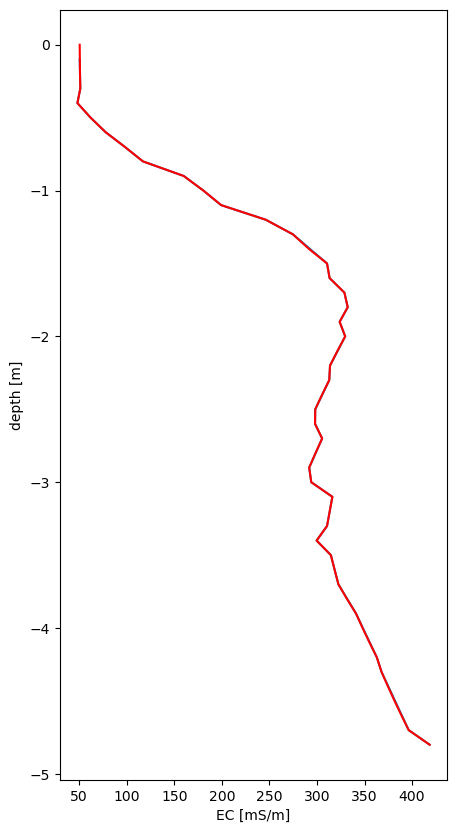

In [117]:
# Visual evaluation of FWD model input
# ------------------------------------ #
profile_id = 26
dataset_name = 'Resistivity(ohm.m)'
layers_interfaces = np.cumsum(models[profile_id].thick)
layers_interfaces = np.insert(layers_interfaces, 0, 0)
profile_data = ert_final[ert_final['ID'] == profile_id]

fig, ax = plt.subplots(figsize=(5, 10))
# axs[0].plot(models[profile_id].con,-layers_interfaces)
# axs[1].plot((1/profile_data[dataset_name]),profile_data['Z'])
ax.set_xlabel('EC [mS/m]')
ax.set_ylabel('depth [m]')
ax.plot((1/profile_data[dataset_name])*1000,profile_data['Z'], label='ERT',)
ax.plot(models[profile_id].con*1000,-layers_interfaces, label='Mod_in', color = 'red')

In [118]:
# Set instrument properties to use in FWD modelling
# ------------------------------------------------ #

# Assigning to sensor object (S)
#S = FDEM.CoilConfiguration(height, freq, x, ori, mom, 200)

instrument = FDEM.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                    instrument_orientation=config['instrument_orientation']
                                    )

# Forward model the responses of each coil configuration at each of the profile locations
# --------------------------------------------------------------------------------------

forward_results = {}

for profile_id, model in models.items():
    forward_results[profile_id] = {}
    for coil_id, cc in enumerate(instrument.cc_names):
        if 'QP' in cc:
            pair = Mod.Pair1D(getattr(instrument, cc), model)
            IP, QP = pair.forward()
            forward_results[profile_id][cc] = {'IP': IP, 'QP': QP}


c:\Users\gmendoza\OneDrive - UGent\Documentos\PhD\EM case survey\EMI_survey_code\FDEM\Modeling.py:427: RuntimeWarning: overflow encountered in tanh
  tanh_uh = np.tanh(u[:, i] * self.model.thick[i])


In [119]:
# Check the forward model results for a given profile
# IP and QP data are in ppm !!!
profile_id = 13
sensor_id = 'HCP1QP'
ip_result = forward_results[profile_id][sensor_id]['IP']
qp_result = forward_results[profile_id][sensor_id]['QP']

print(f"IP for profile {profile_id} with sensor {sensor_id}: {ip_result}")
print(f"QP for profile {profile_id} with sensor {sensor_id}: {qp_result}")

IP for profile 13 with sensor HCP1QP: [352.62806355]
QP for profile 13 with sensor HCP1QP: [1530.87635361]


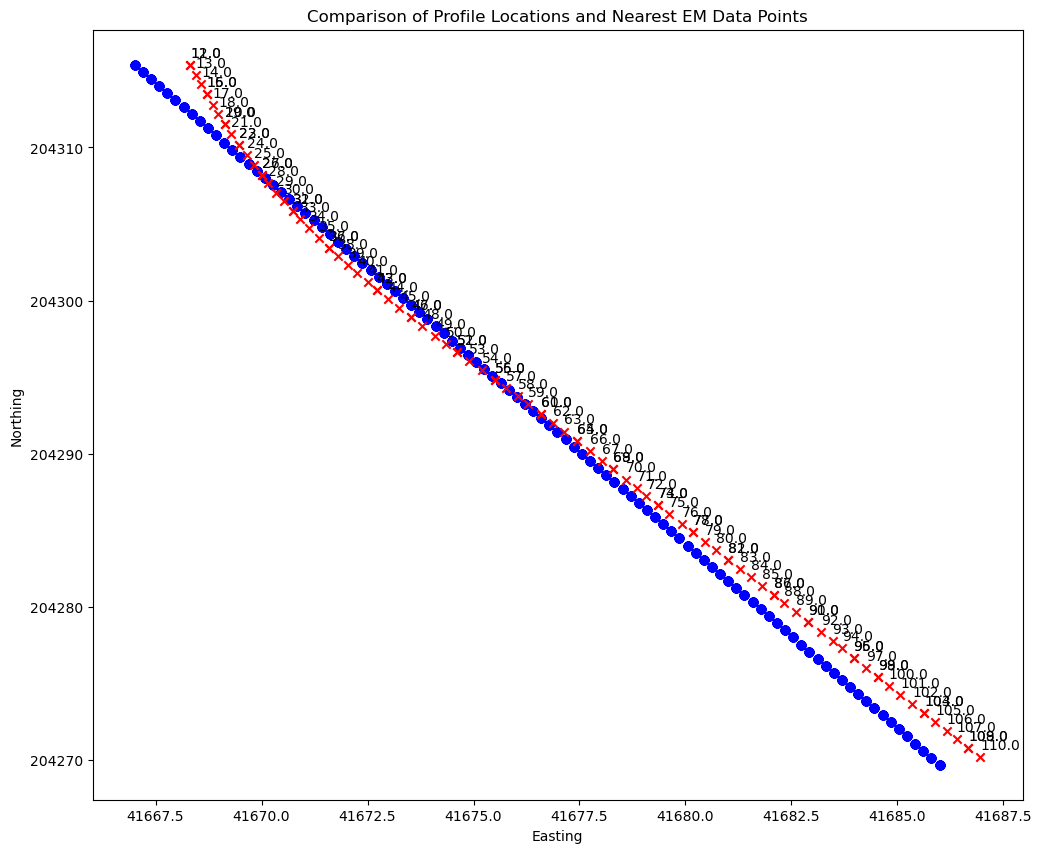

In [120]:
# Check location offset between ERT electrode locations and EMI measurements
# --------------------------------------------------------------------------

# Creating kd-tree for the EM data points
tree = cKDTree(EM_data[['x', 'y']].values)

# Dictionary to hold the nearest EM data points to each profile
nearest_EM_data_points = {}

for profile_id, profile_data in ert_final.groupby('ID'):
    if profile_id in all_profiles_df['ID'].unique():
        profile_location = np.array([profile_data['easting'].mean(), profile_data['northing'].mean()])

        # Query the tree for the nearest point
        distance, index = tree.query(profile_location, k=1)  # k=1 means we want the nearest point
        
        # Retrieve the EM data point that is closest to the profile location
        nearest_EM_data_points[profile_id] = EM_data.iloc[index]
        nearest_EM_data_points[profile_id]['p_ID'] = profile_id

# Scatter plot of the profile locations
plt.figure(figsize=(12, 10))

# Plot the profile points
for profile_id, profile_data in ert_final.groupby('ID'):
    if profile_id in all_profiles_df['ID'].unique():
        plt.scatter(profile_data['easting'], profile_data['northing'], 
                    color='blue', label='Profile Locations' if profile_id == 1 else "")

# Plot the nearest EM data points
for profile_id, em_point in nearest_EM_data_points.items():
    if profile_id in all_profiles_df['ID'].unique():
        plt.scatter(em_point['x'], em_point['y'], color='red', marker='x')
        plt.text(em_point['x'], em_point['y']+.5, str(profile_id), color='black')

# Adding labels and legend
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Comparison of Profile Locations and Nearest EM Data Points')

plt.show()

In [121]:
# Create dataframe from EM data over ERT transect for comparison and exporting
EM_transect = pd.DataFrame.from_dict(nearest_EM_data_points, orient='index')

# If you want to ensure that the p_ID is a column and not an index, you can reset the index:
EM_transect.reset_index(drop=True, inplace=True)
#EM_transect.columns

# Forward model at transect locations
forward_results = {}

for profile_id, model in models.items():
    forward_results[profile_id] = {}
    for coil_id, cc in enumerate(instrument.cc_names):
        if 'QP' in cc:
            coilconfig = getattr(instrument, cc)
            # Forward model
            pair = Prop.Modeling.Pair1D(coilconfig, model)
            IP, QP = pair.forward()
            # Convert fwd modelled result to LIN ECa to match sensor output
            eca = Prop.qp_to_mcneill(coilconfig, QP[0], qp_input_units='ppm', eca_output_units='mS')
            forward_results[profile_id][cc] = eca

c:\Users\gmendoza\OneDrive - UGent\Documentos\PhD\EM case survey\EMI_survey_code\FDEM\Modeling.py:427: RuntimeWarning: overflow encountered in tanh
  tanh_uh = np.tanh(u[:, i] * self.model.thick[i])


In [122]:
# Create a dataframe that combines the EM data along the transect and 
#   the forward modelled EM responses based on ERT data
# ---------------------------------------------------------------------------- #

data_for_df = []

# Iterate over the profile IDs in the nearest_EM_data_points dictionary
for profile_id, em_data in nearest_EM_data_points.items():
    if profile_id in ert_final['ID'].unique():
        forward_data = forward_results[profile_id]
        
        # Construct the row for this profile
        row = {
            'ID': profile_id,
            'x_ert': em_data['x'],
            'y_ert': em_data['y'],
            'x_em': em_data['x'],
            'y_em': em_data['y']
        }
        
        # Add the EM sensor data from the 'nearest_EM_data_points'
        for cc in instrument.cc_names:
            if 'QP' in cc:
                row[f'EM_{cc}'] = em_data[cc]

        # Add the forward modelled sensor data from the 'forward_results'
        for cc in instrument.cc_names:
            if 'QP' in cc:
                row[f'forward_{cc}'] = forward_data[cc]

        # Add the row to our list
        data_for_df.append(row)

# Create the DataFrame
combined_df = pd.DataFrame(data_for_df)
combined_df.to_csv(os.path.join(datafolder, f'{emfile_prefix}_{cl}_{percent}_combined.csv'), index=False)

comb_dfM = pd.read_csv(os.path.join(datafolder, f'middelkerke_421S_raw_{cl}_{percent}_combined.csv'))
comb_dfP = pd.read_csv(os.path.join(datafolder, f'proefhoeve_21HS_raw_{cl}_{percent}_combined.csv'))

print(comb_dfM.head())
print(comb_dfP.head())

     ID        x_ert        y_ert         x_em         y_em  EM_HCP1QP  \
0  11.0  41668.31481  204315.4004  41668.31481  204315.4004      105.4   
1  12.0  41668.31481  204315.4004  41668.31481  204315.4004      105.4   
2  13.0  41668.44947  204314.7587  41668.44947  204314.7587      108.6   
3  14.0  41668.57399  204314.1439  41668.57399  204314.1439      111.1   
4  15.0  41668.70589  204313.4887  41668.70589  204313.4887      114.0   

   EM_PRP1QP  EM_HCP2QP  EM_PRP2QP  EM_HCP4QP  EM_PRP4QP  forward_HCP1QP  \
0       39.9      131.6       73.9      148.0      127.5       80.124518   
1       39.9      131.6       73.9      148.0      127.5       82.474070   
2       41.9      136.0       78.2      149.4      135.0       86.172336   
3       46.3      139.3       81.1      152.1      143.4       94.758764   
4       49.5      144.3       86.2      155.4      151.2      102.681858   

   forward_PRP1QP  forward_HCP2QP  forward_PRP2QP  forward_HCP4QP  \
0       42.368914      106.25

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


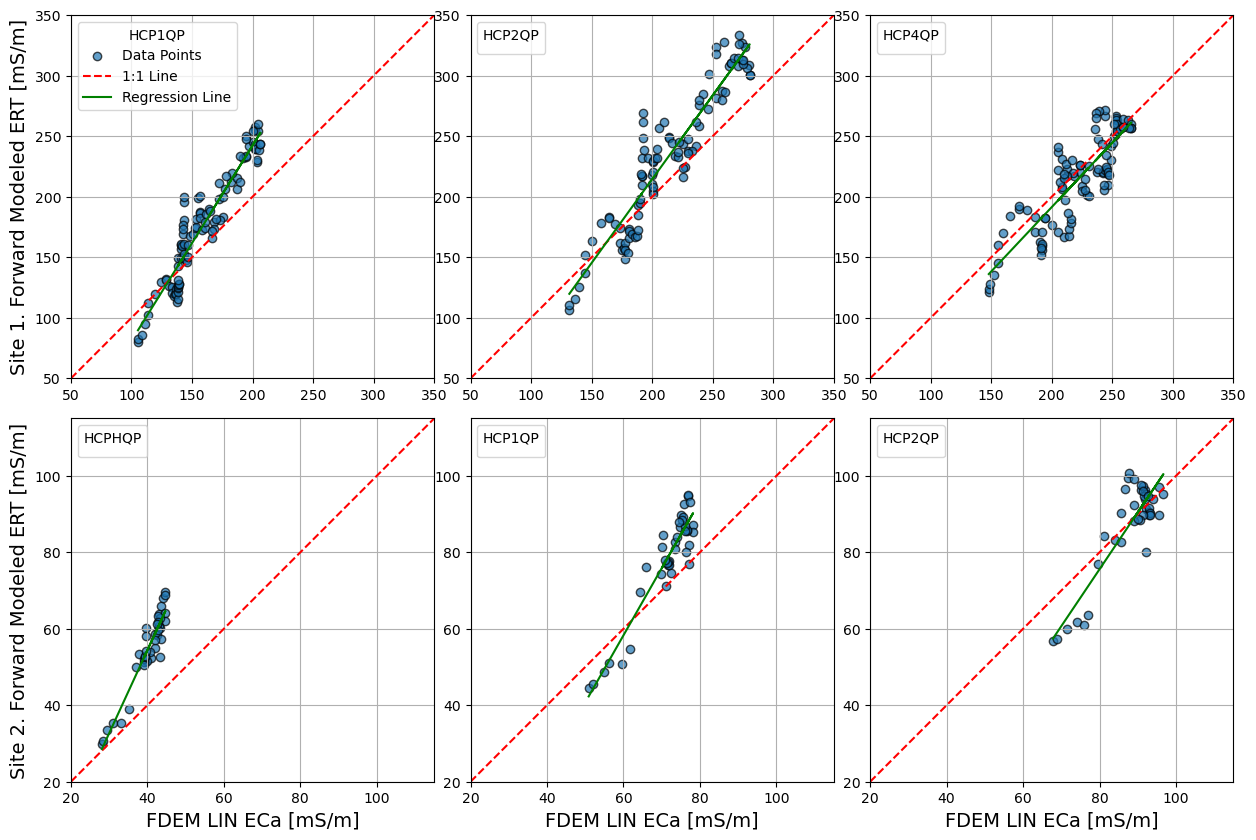

In [123]:
# Setup figure
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Define configurations to plot
column_configs = ['HCP1QP', 'HCP2QP', 'HCP4QP', 'HCPHQP', 'HCP1QP', 'HCP2QP']

# Fixed axis limits
left_min, left_max = 50, 350
right_min, right_max = 20, 115

# Store regression parameters
regression_params = {}

# Plotting logic for Site 1 (comb_dfM)
for i in range(num_cols):
    measured_col = f'EM_{column_configs[i]}'
    modeled_col = f'forward_{column_configs[i]}'  # Assumes naming convention
    X = comb_dfM[measured_col].values.reshape(-1, 1)
    y = comb_dfM[modeled_col].values
    regression = LinearRegression().fit(X, y)
    regression_params[measured_col] = (regression.coef_[0], regression.intercept_)
    reg_line = regression.predict(X)

    ax = axes[0, i]
    ax.grid(True)

    if ax == axes[0, 0]:
        scatter = ax.scatter(X, y, edgecolor='k', alpha=0.7, label='Data Points')
        ax.plot([left_min, left_max], [left_min, left_max], 'r--', label='1:1 Line')
        ax.plot(X, reg_line, 'g-', label='Regression Line')
    else:
        scatter = ax.scatter(X, y, edgecolor='k', alpha=0.7)
        ax.plot([left_min, left_max], [left_min, left_max], 'r--')
        ax.plot(X, reg_line, 'g-')
        
    ax.set_xlim([left_min, left_max])
    ax.set_ylim([left_min, left_max])
    ax.set_aspect('equal', adjustable='box')  # Setting aspect ratio to equal
    ax.legend(title=measured_col.replace('EM_', ''), loc='upper left')

    # Remove y-axis labels for center and right columns
    if i > 0:
        ax.set_ylabel('')

axes[0, 0].set_ylabel('Site 1. Forward Modeled ERT [mS/m]', fontsize=14)

# Plotting logic for Site 2 (comb_dfP)
for i in range(num_cols):
    measured_col = f'EM_{column_configs[i+3]}'
    modeled_col = f'forward_{column_configs[i+3]}'  # Assumes naming convention
    if measured_col in comb_dfP.columns and modeled_col in comb_dfP.columns:
        X = comb_dfP[measured_col].values.reshape(-1, 1)
        y = comb_dfP[modeled_col].values
        regression = LinearRegression().fit(X, y)
        regression_params[measured_col] = (regression.coef_[0], regression.intercept_)
        reg_line = regression.predict(X)

        ax = axes[1, i]
        ax.grid(True)
        scatter = ax.scatter(X, y, edgecolor='k', alpha=0.7)
        ax.plot([right_min, right_max], [right_min, right_max], 'r--')
        ax.plot(X, reg_line, 'g-')
        ax.set_xlim([right_min, right_max])
        ax.set_ylim([right_min, right_max])
        ax.set_aspect('equal', adjustable='box')  # Setting aspect ratio to equal
        ax.legend(title=measured_col.replace('EM_', ''), loc='upper left')
    else:
        ax = axes[1, i]
        ax.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_yticks([])

    # Remove y-axis labels for center and right columns
    if i > 0:
        ax.set_ylabel('')

axes[1, 0].set_ylabel('Site 2. Forward Modeled ERT [mS/m]', fontsize=14)

# Set common xlabel
for ax in axes[1, :]:
    ax.set_xlabel(f'FDEM LIN ECa [mS/m]', fontsize=14)

# Adjust layout to reduce white spaces
plt.subplots_adjust(hspace=0.1, wspace=0.1)

# Save and show the plot
cal_metaname = os.path.join('output_images', f'{emfile_prefix}_calibration_plots_'+str(cl)+'_'+str(percent)+'.png')
plt.savefig(cal_metaname, dpi=300)
plt.show()

In [124]:
# Implement EM calibration through regression parameters
# ----------------------------------------------------- 

cal_EM = EM_data.copy()
cal_trans = EM_transect.copy()

# Perform the calibration
for coil_config, (slope, intercept) in regression_params.items():
    if coil_config in cal_EM.columns:  # Only apply if the coil_config is a column in the DataFrame
        #print(f"{coil_config}: Mod = {slope:.3f} ECa + {intercept:.3f}")
        cal_EM[coil_config] = slope * cal_EM[coil_config] + intercept
        cal_trans[coil_config] = slope * cal_trans[coil_config] + intercept
        #print('calibrated')

cal_r_EM = cal_EM.copy()
cal_r_trans = cal_trans.copy()
EM_transect_r = EM_transect.copy()

# Convert calibrated data to LIN ECa and rECa
for cc in instrument.cc_names:  # Only apply if the coil_config is a column in the DataFrame
    if 'QP' in cc:
        print('cc', cc)
        coil_configuration = getattr(instrument, cc)

        print('coil_configuration', coil_configuration)

        ip_config = cc[:-2]+'IP'

        # convert to QP to prepare for rECa prediction
        qp = Prop.mcneill_to_qp(coil_configuration, 
                                cal_EM[cc], 
                                eca_input_units='mS', 
                                qp_output_units='ppm')
        # perform rECa prediction

        cal_r_EM[cc], _ = Prop.reca(coil_configuration, 
                                        qp, 
                                        cal_EM[ip_config]*1000, 
                                        precision=.001, 
                                        noise=0, 
                                        reference_eca=None, 
                                        original_msa=0, 
                                        alternative_msa=0, 
                                        maximum_eca=4)
        # convert from S/m to mS/m
        cal_r_EM[cc] = cal_r_EM[cc]*1000

        ## TRANSECT
        # convert to QP to prepare for rECa prediction
        qp = Prop.mcneill_to_qp(coil_configuration, 
                                cal_r_trans[cc], 
                                eca_input_units='mS', 
                                qp_output_units='ppm')
        
        qp_uncal = Prop.mcneill_to_qp(coil_configuration, 
                                EM_transect[cc], 
                                eca_input_units='mS', 
                                qp_output_units='ppm')
        
        # perform rECa prediction
        cal_r_trans[cc], _ = Prop.reca(coil_configuration, 
                                        qp, 
                                        cal_trans[ip_config]*1000, 
                                        precision=.001, 
                                        noise=0, 
                                        reference_eca=None, 
                                        original_msa=0, 
                                        alternative_msa=0, 
                                        maximum_eca=4)
        
        EM_transect_r[cc], _ = Prop.reca(coil_configuration, 
                                        qp_uncal, 
                                        EM_transect[ip_config]*1000, 
                                        precision=.001, 
                                        noise=0, 
                                        reference_eca=None, 
                                        original_msa=0, 
                                        alternative_msa=0, 
                                        maximum_eca=4)

        # convert from S/m to mS/m
        cal_r_trans[cc] = cal_r_trans[cc]*1000
        EM_transect_r[cc] = EM_transect_r[cc]*1000
        print(f"Modeled robust {cc} ECa, median = {cal_r_trans[cc].median()} vs median = {cal_trans[cc].median()} ")

print(cal_r_EM)

cc HCP1QP
coil_configuration <FDEM.Initialize.CoilConfiguration object at 0x0000023E060AC9D0>
Modeled robust HCP1QP ECa, median = 177.21835787316311 vs median = 153.6 
cc PRP1QP
coil_configuration <FDEM.Initialize.CoilConfiguration object at 0x0000023E060AC890>
Modeled robust PRP1QP ECa, median = 75.90558194220412 vs median = 54.0 
cc HCP2QP
coil_configuration <FDEM.Initialize.CoilConfiguration object at 0x0000023E060AED10>
Modeled robust HCP2QP ECa, median = 258.11146575475556 vs median = 203.6 
cc PRP2QP
coil_configuration <FDEM.Initialize.CoilConfiguration object at 0x0000023E07925E50>
Modeled robust PRP2QP ECa, median = 138.65315459293328 vs median = 116.0 
cc HCP4QP
coil_configuration <FDEM.Initialize.CoilConfiguration object at 0x0000023E06674310>
Modeled robust HCP4QP ECa, median = 446.56529980179533 vs median = 224.8 
cc PRP4QP
coil_configuration <FDEM.Initialize.CoilConfiguration object at 0x0000023E079C1A10>
Modeled robust PRP4QP ECa, median = 232.8815043888461 vs median = 20

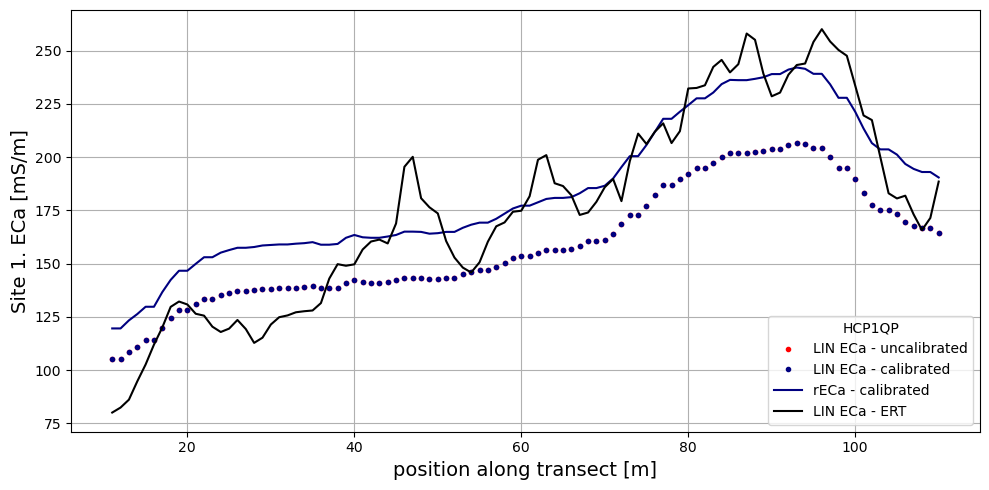

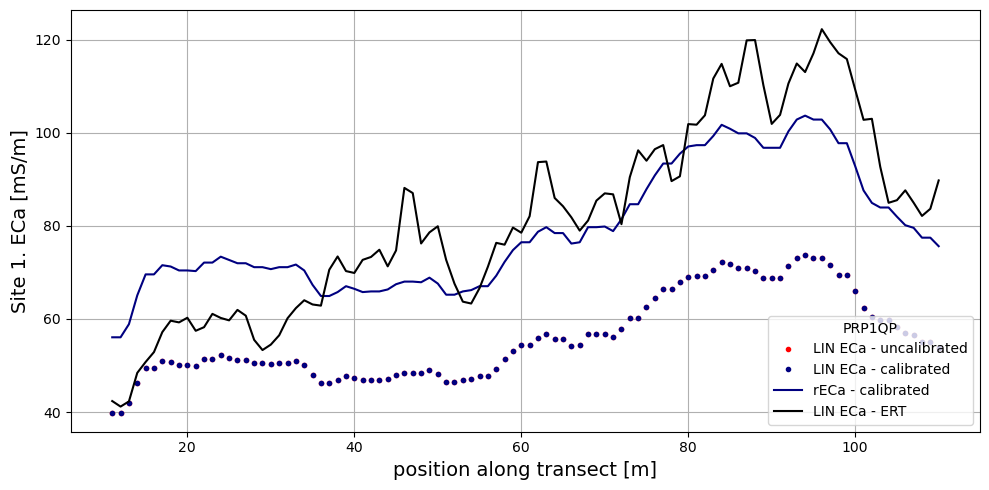

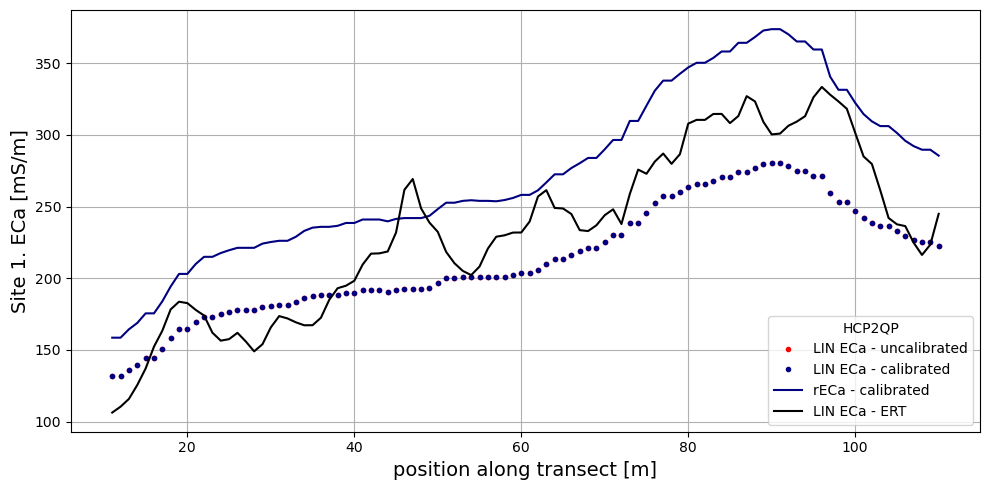

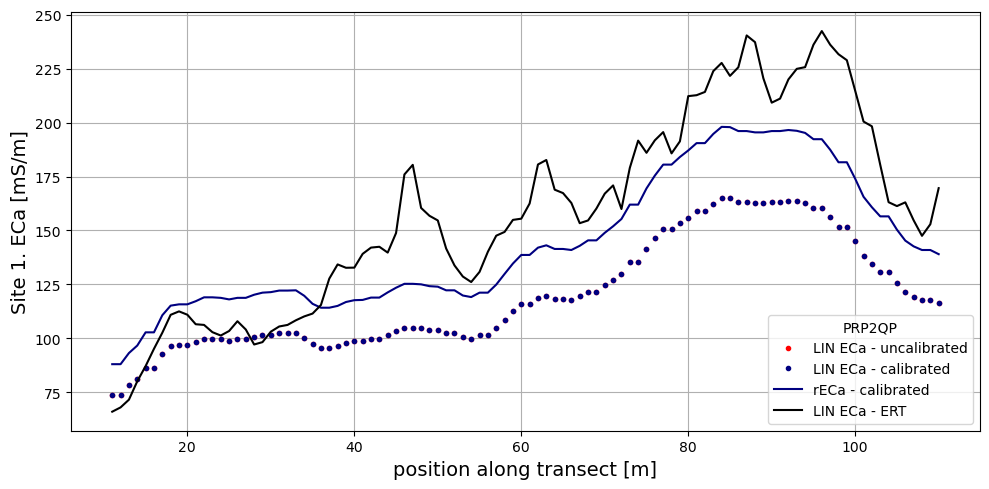

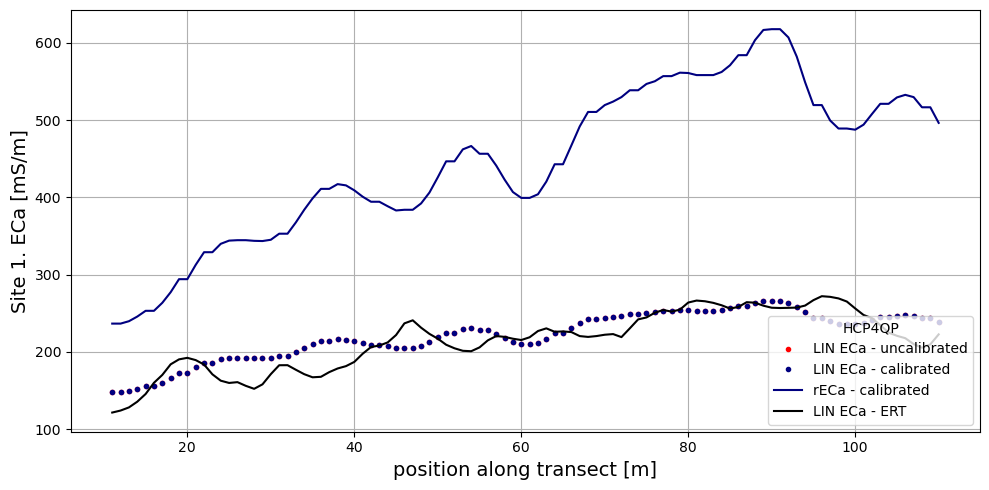

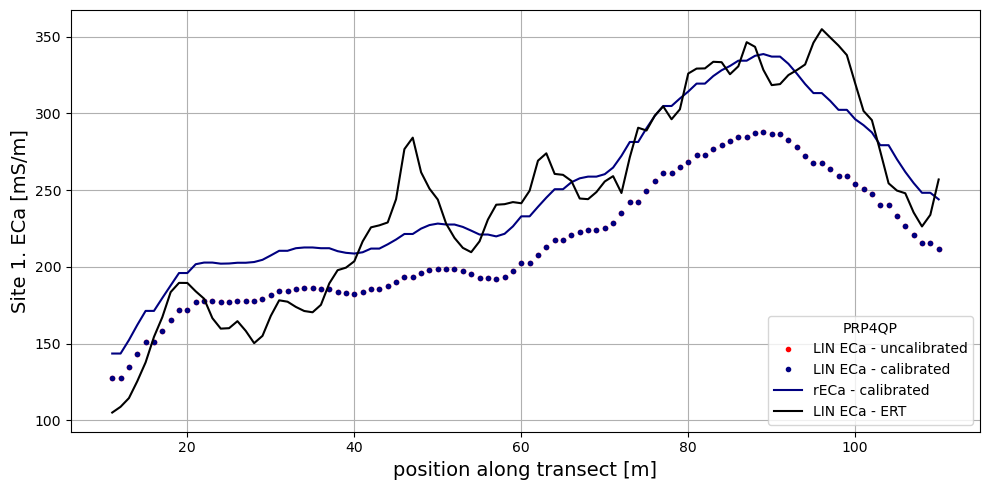

In [125]:
def transect_pos_from_xy(x, y):
    """
    Calculate the positions of points along a transect and the transect's orientation relative to geographic north.

    Parameters:
    x (numpy.ndarray): An array of x-coordinates (longitude or easting) of points along the transect.
    y (numpy.ndarray): An array of y-coordinates (latitude or northing) of points along the transect.

    The arrays x and y must be of the same length.

    Returns:
    tuple: A tuple containing two elements:
        - A numpy.ndarray of positions along the transect, starting from 0.
        - A float representing the orientation of the transect in degrees from north (0 to 360 degrees).

    The position is calculated as the cumulative distance from the starting point (northernmost or westernmost),
    and the orientation is the angle between the line connecting the first and last points of the transect and geographic north.
    """

    # Combine x and y into a single array for sorting
    points = np.column_stack((x, y))
    # Sort points by northernmost or westernmost (y first, then x)
    points = points[np.lexsort((points[:, 0], points[:, 1]))]
    # Calculate differences
    differences = np.diff(points, axis=0)
    # Calculate Euclidean distances for each transect segment
    distances = np.sqrt(np.sum(differences**2, axis=1))
    # Calculate cumulative distance
    positions = np.cumsum(distances)
    positions = np.insert(positions, 0, 0)  # Add 0 at the start
    # Calculate orientation (angle to geographic north)
    dx = points[-1, 0] - points[0, 0]
    dy = points[-1, 1] - points[0, 1]
    angle_radians = np.arctan2(dx, dy)
    angle_degrees = np.degrees(angle_radians)

    # Adjust the angle to be between 0 and 360 degrees
    orientation = angle_degrees % 360

    return positions, orientation

positions, orientation = transect_pos_from_xy(EM_transect['x'].values, EM_transect['y'].values) 

pdf_files = []
for cc in instrument.cc_names:  

    if 'QP' in cc:
        measured_col = f'EM_{cc}'
        modeled_col = f'forward_{cc}'
        
        # Perform linear regression
        X = combined_df[measured_col].values.reshape(-1, 1)
        ert_fwd = combined_df[modeled_col].values
        coil_label = cc[:-2]
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_xlabel('position along transect [m]', fontsize=14)

        if s_site == 'P':
            ax.set_ylabel('Site 2. ECa [mS/m]', fontsize=14)
        elif s_site == 'M':
            ax.set_ylabel('Site 1. ECa [mS/m]', fontsize=14)
            
        ax.plot(EM_transect['p_ID'], EM_transect[cc],'.',color = 'red', label=f"LIN ECa - uncalibrated")        
        ax.plot(cal_trans['p_ID'], cal_trans[cc],'.',color = 'navy', label=f"LIN ECa - calibrated")   
        ax.plot(cal_r_trans['p_ID'], cal_r_trans[cc],color = 'navy', label=f"rECa - calibrated ")
        ax.plot(combined_df['ID'], ert_fwd,color = 'black', label=f"LIN ECa - ERT ")
        ax.grid(True)  # Add grid
        ax.legend(loc='lower right', fontsize=10, title=f"{coil_label}QP")  # Move title to legend
        
        fig.tight_layout()

        filename = f"{emfile_prefix}_{coil_label}"

        plt.savefig('output_images/'+filename+'.png', dpi= 500)

In [126]:
EM_transect.head()
combined_df.head()


,ID,x_ert,y_ert,x_em,y_em,EM_HCP1QP,EM_PRP1QP,EM_HCP2QP,EM_PRP2QP,EM_HCP4QP,EM_PRP4QP,forward_HCP1QP,forward_PRP1QP,forward_HCP2QP,forward_PRP2QP,forward_HCP4QP,forward_PRP4QP
0,11.0,41668.31481,204315.4004,41668.31481,204315.4004,105.4,39.9,131.6,73.9,148.0,127.5,80.124518,42.368914,106.255350,66.003834,121.314321,105.049834
1,12.0,41668.31481,204315.4004,41668.31481,204315.4004,105.4,39.9,131.6,73.9,148.0,127.5,82.474070,41.181751,110.352581,67.993362,123.919667,108.796921
2,13.0,41668.44947,204314.7587,41668.44947,204314.7587,108.6,41.9,136.0,78.2,149.4,135.0,86.172336,42.292649,115.775509,71.564819,127.971038,114.450714
3,14.0,41668.57399,204314.1439,41668.57399,204314.1439,111.1,46.3,139.3,81.1,152.1,143.4,94.758764,48.421957,125.455993,80.089676,135.363073,125.446456
4,15.0,41668.70589,204313.4887,41668.70589,204313.4887,114.0,49.5,144.3,86.2,155.4,151.2,102.681858,50.758396,136.955630,87.141301,145.345904,137.754513


In [127]:
if export_results:
    def create_calibrated_file_path(directory, original_filename, suffix, extension, folder_name='calibrated'):
        # Create the calibrated folder path
        cal_folder_path = os.path.join(directory, folder_name)

        # Ensure the calibrated folder exists
        if not os.path.exists(cal_folder_path):
            os.makedirs(cal_folder_path)

        # Create the new calibrated file name
        cal_filename = f"{original_filename}_{suffix}{extension}"

        # Return the full path of the new calibrated file
        return os.path.join(cal_folder_path, cal_filename)

    def save_csv_without_default_index(df, file_path):
        # Check if the index is the default integer index
        if (df.index == pd.RangeIndex(start=0, stop=len(df))).all():
            # If the index is the default, save without the index
            df.to_csv(file_path, index=False)
        else:
            # If the index is meaningful, save with the index
            df.to_csv(file_path)

        if 'geometry' in df.columns:
            df.drop('geometry',axis=1, inplace=True)

    # Extracting directory 
    em_extension = '.csv'

    # Using the function to create paths
    cal_survey_path = create_calibrated_file_path(datafolder, emfile_prefix, 'calibrated_LIN_'+str(cl)+'_'+str(percent), em_extension)
    cal_transect_path = create_calibrated_file_path(datafolder, emfile_prefix, 'transect_calibrated_'+str(cl)+'_'+str(percent), em_extension)
    uncal_transect_path = create_calibrated_file_path(datafolder, emfile_prefix, 'transect_uncalibrated_LIN_'+str(cl)+'_'+str(percent), em_extension)
    uncal_transect_r_path = create_calibrated_file_path(datafolder, emfile_prefix, 'transect_uncalibrated_LIN_'+str(cl)+'_'+str(percent), em_extension)
    cal_r_EM_path = create_calibrated_file_path(datafolder, emfile_prefix, 'calibrated_rECa_'+str(cl)+'_'+str(percent), em_extension)
    cal_r_trans_path = create_calibrated_file_path(datafolder, emfile_prefix, 'transect_calibrated_rECa_'+str(cl)+'_'+str(percent), em_extension)

    # Saving dataframes to the respective paths using the new function
    save_csv_without_default_index(cal_EM, cal_survey_path)
    save_csv_without_default_index(cal_trans, cal_transect_path)
    save_csv_without_default_index(cal_r_EM, cal_r_EM_path)
    save_csv_without_default_index(cal_r_trans, cal_r_trans_path)
    save_csv_without_default_index(EM_transect, uncal_transect_path)
    save_csv_without_default_index(EM_transect_r, uncal_transect_r_path)
